In [2]:
import pickle
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline

In [2]:
!ls data

champs-scalar-coupling.zip        scalar_coupling_contributions.csv
dipole_moments.csv                structures.csv
magnetic_shielding_tensors.csv    structures.zip
mulliken_charges.csv              test.csv
potential_energy.csv              train.csv
sample_submission.csv


In [5]:
!head data/train.csv

id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,dsgdb9nsd_000001,1,2,2JHH,-11.257
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,dsgdb9nsd_000001,2,0,1JHC,84.8074
5,dsgdb9nsd_000001,2,3,2JHH,-11.2541
6,dsgdb9nsd_000001,2,4,2JHH,-11.2548
7,dsgdb9nsd_000001,3,0,1JHC,84.8093
8,dsgdb9nsd_000001,3,4,2JHH,-11.2543


In [6]:
train = pd.read_csv('data/train.csv')

In [7]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [18]:
train['type'].value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

In [24]:
scalar_coupling_constant_by_type_stats = (
    train
    .groupby('type')
    ['scalar_coupling_constant']
    .describe()
    .unstack()
)
scalar_coupling_constant_by_type_stats

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
1JHC,709416.0,94.976153,18.277237,66.60080,84.023000,88.223650,100.735000,204.8800
1JHN,43363.0,47.479884,10.922172,24.32220,36.496800,47.789400,57.053100,80.4187
2JHC,1140674.0,-0.270624,4.523611,-36.21860,-2.226068,-0.949123,0.870188,42.8192
2JHH,378036.0,-10.286605,3.979607,-35.17610,-12.026800,-11.328700,-9.643585,11.8542
2JHN,119253.0,3.124754,3.673474,-2.62085,0.190584,2.018590,5.276480,17.7436
3JHC,1510379.0,3.688470,3.070907,-18.58210,1.311865,2.880310,5.672480,76.0437
3JHH,590611.0,4.771023,3.704984,-3.02046,2.047675,3.691440,7.333505,17.4841
3JHN,166415.0,0.990730,1.315393,-3.17241,0.106232,0.658849,1.435225,10.9712


In [28]:
median_coupling_by_type = dict(zip(
    scalar_coupling_constant_by_type_stats.index,
    scalar_coupling_constant_by_type_stats['50%']))
median_coupling_by_type

{'1JHC': 88.22364999999999,
 '1JHN': 47.7894,
 '2JHC': -0.9491225000000001,
 '2JHH': -11.3287,
 '2JHN': 2.01859,
 '3JHC': 2.8803099999999997,
 '3JHH': 3.69144,
 '3JHN': 0.658849}

In [9]:
!head data/structures.csv

molecule_name,atom_index,atom,x,y,z
dsgdb9nsd_000001,0,C,-0.0126981359,1.085804158,0.0080009958
dsgdb9nsd_000001,1,H,0.002150416,-0.0060313176,0.0019761204
dsgdb9nsd_000001,2,H,1.011730843,1.463751162,0.0002765748
dsgdb9nsd_000001,3,H,-0.540815069,1.447526614,-0.8766437152
dsgdb9nsd_000001,4,H,-0.5238136345,1.437932644,0.9063972942
dsgdb9nsd_000002,0,N,-0.0404260543,1.024107753,0.0625637998
dsgdb9nsd_000002,1,H,0.0172574639,0.0125452063,-0.0273771593
dsgdb9nsd_000002,2,H,0.9157893661,1.358745195,-0.0287577581
dsgdb9nsd_000002,3,H,-0.5202777357,1.343532126,-0.7755426124


In [10]:
structures = pd.read_csv('data/structures.csv')

In [123]:
pd.read_csv?

In [11]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [12]:
dipole_moments = pd.read_csv('data/dipole_moments.csv')
dipole_moments.head()

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511
3,dsgdb9nsd_000005,0.0000,0.0,-2.8937
4,dsgdb9nsd_000007,0.0000,0.0,0.0000


In [13]:
magnetic_shielding_tensors = pd.read_csv('data/magnetic_shielding_tensors.csv')
magnetic_shielding_tensors.head()

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013


In [14]:
mulliken_charges = pd.read_csv('data/mulliken_charges.csv')
mulliken_charges.head()

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


In [15]:
potential_energy = pd.read_csv('data/potential_energy.csv')
potential_energy.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


In [16]:
scalar_coupling_contributions = pd.read_csv('data/scalar_coupling_contributions.csv')
scalar_coupling_contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [21]:
test = pd.read_csv('data/test.csv')
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [22]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,id,scalar_coupling_constant
0,4658147,0
1,4658148,0
2,4658149,0
3,4658150,0
4,4658151,0


In [32]:
submission = test.copy()
submission['scalar_coupling_constant'] = submission['type'].map(median_coupling_by_type)
submission = submission[['id', 'scalar_coupling_constant']]
submission.head()

,id,scalar_coupling_constant
0,4658147,-0.949123
1,4658148,88.223650
2,4658149,3.691440
3,4658150,88.223650
4,4658151,-0.949123


In [33]:
submission.to_csv('data/submission_median_coupling_by_type.csv', index=False)

In [34]:
!head data/submission_median_coupling_by_type.csv

id,scalar_coupling_constant
4658147,-0.9491225000000001
4658148,88.22364999999999
4658149,3.69144
4658150,88.22364999999999
4658151,-0.9491225000000001
4658152,88.22364999999999
4658153,2.8803099999999997
4658154,-11.3287
4658155,-11.3287


In [35]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [38]:
tqdm?

In [39]:
molecule_atom_to_position = {}
with tqdm(total=len(structures)) as t:
    for _, row in structures.iterrows():
        t.update()
        molecule_atom_to_position[row['molecule_name'], row['atom_index']
        ] = np.array([row['x'], row['y'], row['z']])

100%|██████████| 2358657/2358657 [08:22<00:00, 4693.90it/s]


In [84]:
def compute_distances(atom_pairs):
    acc = []
    with tqdm(total=len(atom_pairs)) as t:
        for _, row in atom_pairs.iterrows():
            t.update()
            molecule_name = row['molecule_name']
            p0 = molecule_atom_to_position[molecule_name, row['atom_index_0']]
            p1 = molecule_atom_to_position[molecule_name, row['atom_index_1']]
            distance = ((p0 - p1)**2).sum()**0.5
            acc.append(distance)
    return pd.Series(acc)

#train2 = train.sample(frac=0.1).reset_index()
train['distance'] = compute_distances(train)

100%|██████████| 4658147/4658147 [15:24<00:00, 5040.82it/s]


In [ ]:
test['distance'] = compute_distances(test)

In [108]:
def create_features(data):
    return np.asarray(pd.concat([data[['distance']], pd.get_dummies(data['type'])], axis=1))

In [109]:
X_train = create_features(train)
y_train = np.asarray(train['scalar_coupling_constant'])
X_test = create_features(test)

In [110]:
from sklearn.ensemble.forest import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=10,
    criterion='mse',
    max_features='auto',
    max_depth=25,
    min_samples_split=1e-5,
    min_samples_leaf=1e-6,
    n_jobs=-1,
    verbose=10
)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

building tree 2 of 10
building tree 4 of 10building tree 3 of 10building tree 1 of 10


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.4min remaining:  1.4min


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   37.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    3.9s remaining:    3.9s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    4.0s remaining:    1.7s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    5.2s finished


In [111]:
submission = test.copy()
submission['scalar_coupling_constant'] = y_predict
submission = submission[['id', 'scalar_coupling_constant']]
submission.head()

,id,scalar_coupling_constant
0,4658147,-0.276368
1,4658148,195.418627
2,4658149,1.138658
3,4658150,195.418627
4,4658151,-0.276368


In [112]:
submission.to_csv('data/submission_dist_type_rf1.csv', index=False)

/Users/matt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


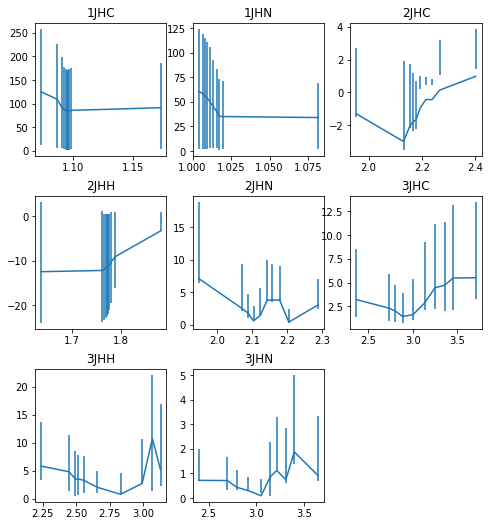

In [120]:
plt.figure(figsize=(8,12))
for tp_i,(tp, train_type) in enumerate(train.groupby('type')):
    train_type['q_dist'] = pd.qcut(train_type['distance'], 10)
    acc = []
    for q_dist, train_q_dist in train_type.groupby('q_dist'):
        start,end = map(float, q_dist[1:-1].split(', '))
        mid = 0.5 * (start + end)
        dsc = train_q_dist['scalar_coupling_constant'].describe()
        p25 = dsc['25%']
        p50 = dsc['50%']
        p75 = dsc['75%']
        acc.append([mid, p25, p50, p75])
    dist, p25, p50, p75 = np.array(acc).T
    plt.subplot(4, 3, tp_i+1)
    plt.title(tp)
    plt.errorbar(dist, p50, [p25, p75])
plt.subplots_adjust(hspace=0.3)

In [122]:
structures['atom'].value_counts()

H    1208387
C     831726
O     183187
N     132361
F       2996
Name: atom, dtype: int64

In [125]:
structures['molecule_name'].nunique()

130775

In [127]:
with open('data/molecules.p', 'rb') as fp:
    molecules = pickle.load(fp)

In [143]:
molecules_by_name = {m.name:m for m in molecules}

In [197]:
#train_1JHC = train[train['type'] == '1JHC']
train_molecule_names = set(train['molecule_name'].drop_duplicates().sample(n=10_000))
train_sample = train[train['molecule_name'].isin(train_molecule_names)]
len(train_sample)

545558

In [198]:
molecules_sample = [m for m in molecules if m.name in train_molecule_names]
len(molecules_sample)

10000

In [139]:
train_1JHC_sample['scalar_coupling_constant'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
scalar_coupling_constant,8543.0,94.611622,18.364187,69.8384,83.68665,87.8273,99.4197,204.426


In [148]:
Counter(
    molecules_by_name[row['molecule_name']].atoms[row['atom_index_0']].atom_type.symbol
    for _,row in train_1JHC_sample.iterrows()
)

Counter({'H': 8543})

In [149]:
Counter(
    molecules_by_name[row['molecule_name']].atoms[row['atom_index_1']].atom_type.symbol
    for _,row in train_1JHC_sample.iterrows()
)

Counter({'C': 8543})

In [199]:
mol_neighbor_counts = {}
with tqdm(molecules_sample) as t:
    for m in t:
        n = len(m.atoms)
        
        atom_distances = np.zeros((n,n), dtype=float)
        for i,ai in enumerate(m.atoms):
            for j in range(i+1, n):
                aj = m.atoms[j]
                d = np.sum((ai.position - aj.position)**2)**0.5
                atom_distances[i,j] = d
                atom_distances[j,i] = d
        
        atom_types = [a.atom_type.symbol for a in m.atoms]
        di, dj = np.where((atom_distances > 0) & (atom_distances < 1.5))
        neighbor_counts = defaultdict(Counter)
        for i,j in zip(di, dj):
            neighbor_counts[i][atom_types[j]] += 1
        
        mol_neighbor_counts[m.name] = neighbor_counts

100%|██████████| 10000/10000 [00:27<00:00, 364.54it/s]


In [201]:
acc_entries = []
with tqdm(total=len(train_sample)) as t:
    for _,row in train_sample.iterrows():
        t.update()
        name = row['molecule_name']
        neighbor_counts = mol_neighbor_counts[name]
        neighbors0 = neighbor_counts[row['atom_index_0']]
        neighbors1 = neighbor_counts[row['atom_index_1']]
        
        entry = {'type': row['type'],
                 'distance': row['distance'],
                 'molecular_weight': molecules_by_name[name].molecular_weight,
                 'scalar_coupling_constant': row['scalar_coupling_constant']}
        for prefix, neighbors in [('n0', neighbors0), ('n1', neighbors1)]:
               for neighbor_type, neighbor_count in neighbors.items():
                    entry[prefix + '_' + neighbor_type] = neighbor_count
        acc_entries.append(entry)

100%|██████████| 545558/545558 [02:14<00:00, 4064.44it/s]


In [202]:
entries = pd.DataFrame(acc_entries).fillna(0)
entries.head()

,distance,molecular_weight,n0_C,n0_N,n0_O,n1_C,n1_F,n1_H,n1_N,n1_O,scalar_coupling_constant,type
0,1.091953,16.0376,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,84.8076,1JHC
1,1.783120,16.0376,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-11.2570,2JHH
2,1.783147,16.0376,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-11.2548,2JHH
3,1.783157,16.0376,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-11.2543,2JHH
4,1.091952,16.0376,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,84.8074,1JHC


In [204]:
X = pd.concat([entries.drop(['scalar_coupling_constant', 'type'], axis=1),                      
               pd.get_dummies(entries['type'])], axis=1)

In [205]:
y = entries['scalar_coupling_constant']

In [219]:
from IPython.display import display
from sklearn.base import clone

for tp, entries_tp in entries.groupby('type'):
    X_tp = entries_tp.drop(['scalar_coupling_constant', 'type'], axis=1)
    y_tp = entries_tp['scalar_coupling_constant']
    model_tp = clone(model)
    model_tp.fit(X_tp, y_tp)
    print(tp)
    display(
        pd.Series(dict(zip(X_tp.columns,
                           model_tp.feature_importances_)))
            .sort_values(ascending=False)
            .round(3)
    )

building tree 4 of 10building tree 3 of 10building tree 2 of 10building tree 1 of 10



building tree 5 of 10
building tree 6 of 10
building tree 7 of 10building tree 8 of 10



[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.4s remaining:    0.6s


building tree 9 of 10building tree 10 of 10

1JHC


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


distance            0.867
n1_O                0.045
n1_C                0.026
n1_N                0.024
molecular_weight    0.021
n1_H                0.016
n1_F                0.000
n0_O                0.000
n0_N                0.000
n0_C                0.000
dtype: float64

building tree 3 of 10building tree 2 of 10building tree 1 of 10
building tree 4 of 10


building tree 5 of 10building tree 6 of 10

building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
1JHN


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


distance            0.894
n1_N                0.041
molecular_weight    0.034
n1_H                0.023
n1_C                0.008
n1_O                0.000
n1_F                0.000
n0_O                0.000
n0_N                0.000
n0_C                0.000
dtype: float64

building tree 4 of 10building tree 2 of 10building tree 3 of 10building tree 1 of 10



building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.9s remaining:    1.3s


building tree 9 of 10
building tree 10 of 10
2JHC


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


distance            0.656
molecular_weight    0.157
n1_C                0.072
n1_H                0.041
n1_O                0.026
n1_N                0.022
n0_N                0.013
n0_C                0.010
n0_O                0.004
n1_F                0.000
dtype: float64

building tree 2 of 10building tree 1 of 10building tree 3 of 10
building tree 4 of 10


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


building tree 9 of 10
building tree 10 of 10
2JHH


distance            0.840
molecular_weight    0.067
n0_C                0.028
n1_N                0.027
n0_N                0.019
n1_C                0.018
n1_O                0.000
n1_H                0.000
n1_F                0.000
n0_O                0.000
dtype: float64

building tree 1 of 10building tree 4 of 10building tree 2 of 10building tree 3 of 10



building tree 5 of 10building tree 6 of 10building tree 7 of 10building tree 8 of 10



building tree 9 of 10
building tree 10 of 10
2JHN


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


distance            0.559
molecular_weight    0.198
n1_C                0.092
n1_N                0.066
n1_H                0.043
n1_O                0.023
n0_O                0.012
n0_C                0.004
n0_N                0.003
n1_F                0.000
dtype: float64

building tree 1 of 10building tree 2 of 10building tree 4 of 10building tree 3 of 10



building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.6s remaining:    1.6s


building tree 9 of 10
building tree 10 of 10
3JHC


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


distance            0.626
molecular_weight    0.174
n1_H                0.067
n1_N                0.034
n1_C                0.033
n1_O                0.029
n0_C                0.015
n0_O                0.013
n0_N                0.007
n1_F                0.002
dtype: float64

building tree 1 of 10building tree 2 of 10building tree 3 of 10


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10building tree 7 of 10
building tree 8 of 10



[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.5s remaining:    0.6s


building tree 9 of 10
building tree 10 of 10
3JHH


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished


distance            0.739
n1_O                0.092
molecular_weight    0.071
n0_O                0.063
n1_C                0.011
n0_C                0.009
n0_N                0.007
n1_N                0.007
n1_H                0.000
n1_F                0.000
dtype: float64

building tree 3 of 10
building tree 1 of 10building tree 2 of 10building tree 4 of 10


building tree 5 of 10building tree 6 of 10building tree 7 of 10


building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s


3JHN


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


distance            0.588
molecular_weight    0.174
n1_C                0.091
n0_C                0.041
n1_H                0.039
n1_N                0.035
n0_O                0.013
n0_N                0.011
n1_O                0.007
n1_F                0.000
dtype: float64

In [260]:
molecule = molecules[100]
molecule.atoms

In [261]:
atoms = molecule.atoms
distances = []
for i,ai in enumerate(atoms):
    for j in range(i+1, len(atoms)):
        aj = atoms[j]
        d = ((ai.position - aj.position)**2).sum()**0.5
        distances.append(d)
distances = pd.Series(distances)
distances.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,55.0,2.345584,0.738678,1.090487,1.82316,2.279264,2.86194,4.102166


In [262]:
distances

0     1.547500
1     2.186242
2     1.547498
3     2.121930
4     1.093302
5     1.090487
6     2.394459
7     3.187079
8     2.533724
9     2.394456
10    1.547501
11    1.784997
12    1.482424
13    2.279261
14    2.239757
15    1.090535
16    2.239752
17    2.279264
18    2.866138
19    1.547500
20    2.121930
21    2.533718
22    3.187084
23    2.394456
24    1.090487
25    1.093301
26    2.394456
27    1.482425
28    2.279260
29    2.239755
30    2.866138
31    2.239751
32    2.279263
33    1.090536
34    3.143216
35    2.427124
36    2.208671
37    2.427110
38    3.143217
39    2.208671
40    1.823158
41    2.987901
42    3.623091
43    2.389688
44    2.987900
45    2.857742
46    4.102166
47    3.623097
48    2.857737
49    2.857732
50    2.987901
51    3.935849
52    1.823162
53    2.857731
54    2.987902
dtype: float64

In [271]:
%matplotlib widget


atoms_by_type = defaultdict(list)
for atom in molecule.atoms:
    atoms_by_type[atom.atom_type].append(atom.position)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for atom_type, positions in atoms_by_type.items():
    xs, ys, zs = np.array(positions).T
    ax.scatter(xs, ys, zs, marker='o', s=200, label=atom_type.symbol)
    
for i,ai in enumerate(atoms):
    for j in range(i+1, len(atoms)):
        aj = atoms[j]
        d = ((ai.position - aj.position)**2).sum()**0.5
        tp = ''.join(sorted([ai.atom_type.symbol, aj.atom_type.symbol]))
        
        is_bonded = False
        is_bonded = (
            (tp == 'HH' and d < 1.1) or
            (tp == 'CH' and d < 1.1) or
            (tp == 'CC' and d < 2) or
            (tp == 'CO' and d < 2) or
            (tp == 'HO' and d < 1.3)
        )
        if is_bonded:
            xs, ys, zs = np.array([ai.position, aj.position]).T
            ax.plot(xs, ys, zs, color='k')

plt.legend(loc='upper right')

KeyError: 'widget'